In [ ]:
!pip install pretty_midi
!pip install numpy
!pip install matplotlib
!pip install msaf
!pip install soundfile

In [ ]:
!pip install --upgrade pip
!pip install --upgrade setuptools wheel

In [ ]:
!pip install sf_segmenter

In [16]:
!brew install ffmpeg libsndfile

==> Downloading https://formulae.brew.sh/api/formula.jws.json
######################################################################### 100.0%
==> Downloading https://formulae.brew.sh/api/cask.jws.json
######################################################################### 100.0%
To reinstall 1.2.2, run:
  brew reinstall libsndfile
==> Downloading https://ghcr.io/v2/homebrew/core/ffmpeg/manifests/7.0.1
######################################################################### 100.0%
==> Fetching dependencies for ffmpeg: brotli, giflib, highway, imath, jpeg-turbo, libpng, lz4, zstd, libtiff, little-cms2, openexr, webp, jpeg-xl, libvmaf, aom, aribb24, dav1d, freetype, fontconfig, frei0r, libunistring, libidn2, libtasn1, nettle, p11-kit, libevent, libnghttp2, unbound, gnutls, xorgproto, libxau, libxdmcp, libxcb, libx11, libxext, libxrender, lzo, pixman, cairo, graphite2, icu4c, harfbuzz, fribidi, libunibreak, libass, libbluray, cjson, libmicrohttpd, mbedtls, librist, libsoxr, libssh, lib

## import the necessary libraries

In [17]:
!pip install librosa miditoolkit

  Using cached librosa-0.10.2.post1-py3-none-any.whl.metadata (8.6 kB)
  Using cached audioread-3.0.1-py3-none-any.whl.metadata (8.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.2 MB/s eta 0:00:00a 0:00:01
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached charset_normalizer-3.3.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (33 kB)
  Using cached idna-3.7-py3-none-any.whl.metadata (9.9 kB)
  Using cached certifi-2024.6.2-py3-none-any.whl.metadata (2.2 kB)
Using cached librosa-0.10.2.post1-py3-none-any.whl (260 kB)
Using cached audioread-3.0.1-py3-none-any.whl (23 kB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
   ━━━

In [18]:
import mido
import numpy as np
import matplotlib.pyplot as plt
from sf_segmenter import Segmenter
import librosa

# load MIDI
midi_file = 'Take_On_Me.mid'
mid = mido.MidiFile(midi_file)

In [19]:
# basic information
print(f"Number of tracks: {len(mid.tracks)}")
print(f"Type: {mid.type}")
print(f"Length: {mid.length:.2f} seconds")

# note events
notes = []
for track in mid.tracks:
    time = 0
    for msg in track:
        time += msg.time
        if msg.type == 'note_on' and msg.velocity > 0:
            notes.append((time, msg.note, msg.velocity))
        elif msg.type == 'note_off' or (msg.type == 'note_on' and msg.velocity == 0):
            notes.append((time, msg.note, 0))

# convert to numpy array?
notes = np.array(notes)

Number of tracks: 14
Type: 1
Length: 226.29 seconds


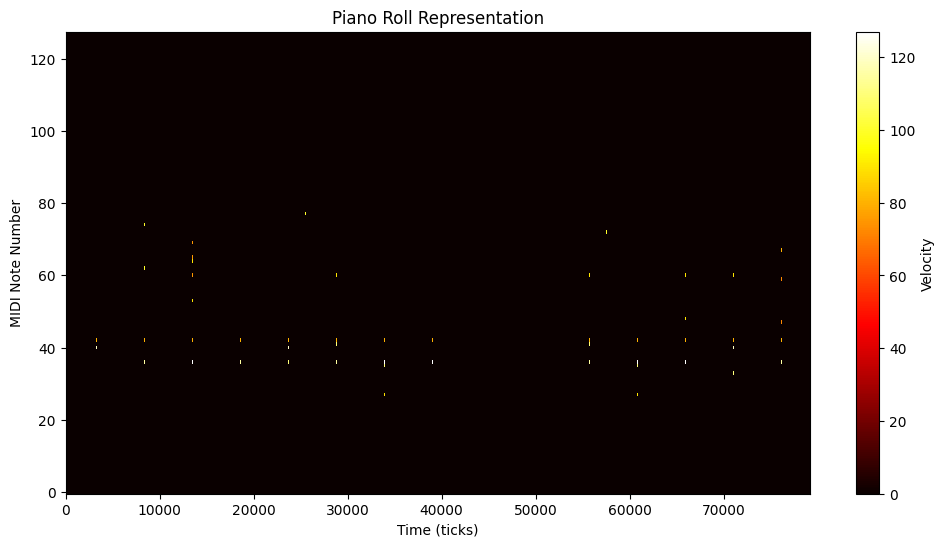

In [20]:
# piano roll
ticks_per_beat = mid.ticks_per_beat
total_ticks = int(max(notes[:, 0]))
piano_roll = np.zeros((128, total_ticks))

for start, pitch, velocity in notes:
    start_tick = int(start)
    if start_tick < total_ticks:
        piano_roll[pitch, start_tick] = velocity

plt.figure(figsize=(12, 6))
plt.imshow(piano_roll, aspect='auto', origin='lower', cmap='hot', interpolation='nearest')
plt.colorbar(label='Velocity')
plt.title('Piano Roll Representation')
plt.xlabel('Time (ticks)')
plt.ylabel('MIDI Note Number')
plt.show()


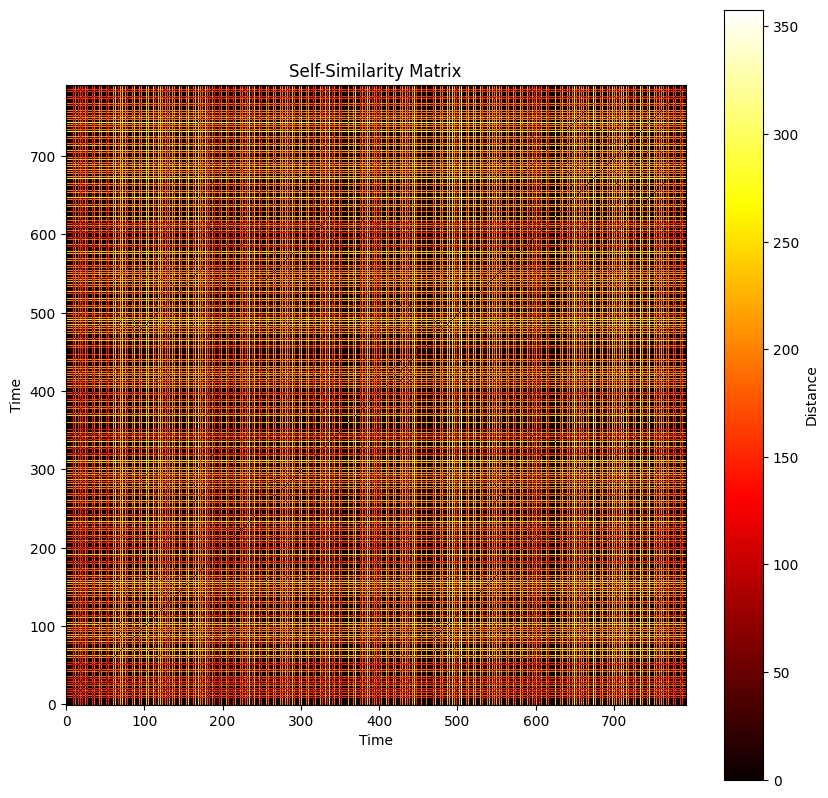

In [21]:
# a simple self-similarity matrix
def compute_ssm(feature_sequence):
    n = feature_sequence.shape[1]
    ssm = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            ssm[i, j] = np.linalg.norm(feature_sequence[:, i] - feature_sequence[:, j])
    return ssm

# downsample piano roll for faster computation?
downsampled_roll = piano_roll[:, ::100]  

ssm = compute_ssm(downsampled_roll)

plt.figure(figsize=(10, 10))
plt.imshow(ssm, cmap='hot', origin='lower', interpolation='nearest')
plt.colorbar(label='Distance')
plt.title('Self-Similarity Matrix')
plt.xlabel('Time')
plt.ylabel('Time')
plt.show()

Segment boundaries (seconds): []


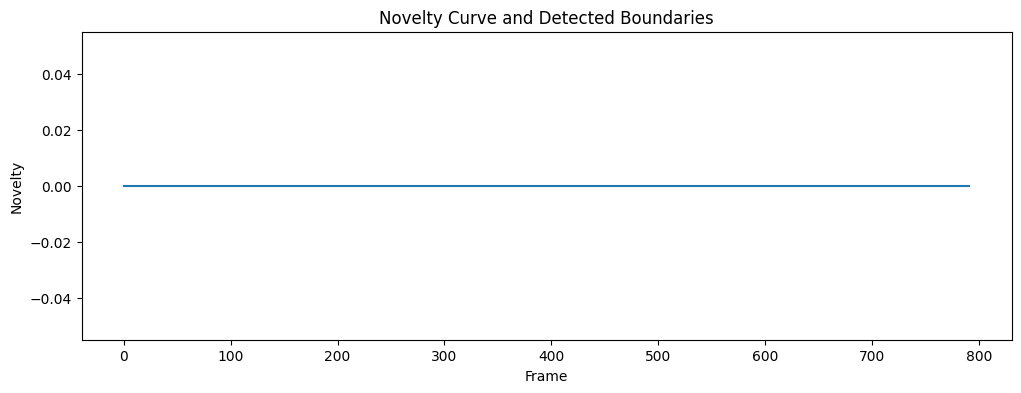

In [24]:
from scipy.signal import find_peaks

# Simple segmentation based on novelty curve
def compute_novelty_curve(ssm):
    kernel = np.eye(7)
    kernel[0, 0] = kernel[-1, -1] = 0.5
    novelty = np.zeros(ssm.shape[0])
    for i in range(3, ssm.shape[0] - 3):
        sub_ssm = ssm[i-3:i+4, i-3:i+4]
        novelty[i] = np.sum(sub_ssm * kernel)
    return novelty

novelty_curve = compute_novelty_curve(ssm)

# peaks in the novelty curve
peaks, _ = find_peaks(novelty_curve, distance=10, prominence=0.1)

# peak positions to seconds
seconds_per_frame = mid.length / ssm.shape[0]
peak_times = peaks * seconds_per_frame

print("Segment boundaries (seconds):", peak_times)

# novelty curve and detected boundaries
plt.figure(figsize=(12, 4))
plt.plot(novelty_curve)
plt.vlines(peaks, ymin=0, ymax=max(novelty_curve), color='r')
plt.title('Novelty Curve and Detected Boundaries')
plt.xlabel('Frame')
plt.ylabel('Novelty')
plt.show()